### Setup

In [ ]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-f9hp3x3v
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-f9hp3x3v


In [ ]:
!unzip "dataset_reshaped.zip"
!unzip "dataset_skeleton.zip"
!unzip "dataset_nodes.zip"
!unzip "dataset_graphs.zip"
!unzip "dataset_features.zip"

unzip:  cannot find or open dataset_reshaped.zip, dataset_reshaped.zip.zip or dataset_reshaped.zip.ZIP.
unzip:  cannot find or open dataset_skeleton.zip, dataset_skeleton.zip.zip or dataset_skeleton.zip.ZIP.
unzip:  cannot find or open dataset_nodes.zip, dataset_nodes.zip.zip or dataset_nodes.zip.ZIP.
unzip:  cannot find or open dataset_graphs.zip, dataset_graphs.zip.zip or dataset_graphs.zip.ZIP.
Archive:  dataset_features.zip
replace dataset_features/image_0.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import os
from os import walk
import math
import random
import threading
from collections import deque


import PIL
from PIL import Image
import cv2 as cv
from google.colab.patches import cv2_imshow
from skimage import img_as_float, img_as_ubyte
from skimage import io, color, morphology, transform, draw
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter, line
from skimage.measure import label

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers

from scipy.stats import norm

In [ ]:
#USEFUL CONSTANTS
RESHAPED_FOLDER_PATH = "/content/dataset_reshaped"
SKELETON_FOLDER_PATH = "/content/dataset_skeleton"
NODES_FOLDER_PATH = "/content/dataset_nodes"
GRAPHS_FOLDER_PATH = "/content/dataset_graphs"
FEATURES_FOLDER_PATH = "/content/dataset_features"
IMG_DIM = 512
DEFAULT_RADIUS = 5
NR_CLUSTERS = 2
LOCK = threading.Lock()

In [ ]:
#UTILITY METHODS
def display_image_compare(*images):
  separator_vertical = np.full((IMG_DIM, 1), 255, dtype=np.uint8)
  separator_horizontal = np.full((1, 3 * (IMG_DIM+1) ), 255, dtype=np.uint8)
  to_display = []
  for img in images:
    if len(to_display) > 0:
      to_display = cv.hconcat((to_display, img))
    else:
      to_display = img
    to_display = cv.hconcat((to_display, separator_vertical))
  to_display = cv.vconcat((to_display, separator_horizontal))
  cv2_imshow(to_display)

def encode_position(position):
  (x, y) = position
  return x * IMG_DIM + y

def decode_position(code):
  x = code // IMG_DIM
  y = code % IMG_DIM

  return (x, y)

In [ ]:
'''
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
'''

"\ndevice_name = tf.test.gpu_device_name()\nif device_name != '/device:GPU:0':\n  raise SystemError('GPU device not found')\nprint('Found GPU at: {}'.format(device_name))\n"

In [ ]:
#return an image having only the pixels within the interval
def extract_color(img_hsv, lower_color, upper_color):
  return (cv.inRange(img_hsv, lower_color, upper_color))

#transform image to skeleton roads
def isolate_roads(pil_image):

  #convert base image to HSV
  img_bgr = cv.cvtColor(np.array(pil_image), cv.COLOR_RGB2BGR)
  img_hsv = cv.cvtColor(img_bgr, cv.COLOR_BGR2HSV)

  cv2_imshow(img_bgr)

  #keep only the blue from the image (roads)
  lower_blue = np.array([100,128,0])
  upper_blue = np.array([180,255,255])
  mask_blue = cv.bitwise_not(extract_color(img_hsv, lower_blue, upper_blue))
  cv2_imshow(mask_blue)

  #apply closing and erosion to keep a simple and smooth representation of roads
  kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
  closing = cv.morphologyEx(mask_blue, cv.MORPH_CLOSE, kernel) #closing removes noise 
  cv2_imshow(closing)
  eroded = cv.erode(closing, kernel, iterations=2) #erosion makes the roads smoother and complete
  cv2_imshow(eroded)

  #skeletonize the image and apply binary dilation to prevent lines from being interrupted
  aux = eroded.copy()
  aux[aux[:]==0] = 1
  aux[aux[:]==255] = 0
  skel = morphology.skeletonize(aux)
  cv2_imshow(img_as_ubyte(skel))
  skel = morphology.binary_dilation(skel, morphology.selem.disk(1))
  skel = img_as_ubyte(skel)
  cv2_imshow(skel)

  return skel

In [ ]:
#returns the angle of the ABC angle
def get_angle(a, b, c):
  ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
  original = ang
  ang = ang + 360 if ang < 0 else ang
  return ((ang - 180 if ang >= 180 else ang), original)

#check if C lies on AB
def on_segment(A, B, C):
  if C[0] <= max(A[0], B[0]) and C[0] >= min(A[0], B[0]) and C[1] <= max(A[1], B[1]) and C[1] >= min(A[1], B[1]):
    return True
  return False

#Given 3 points, check their orientation -> 0 = colinear, 1 = clockwise, -1 = counter-clockwise
def get_orientation(A, B, C):

  val = ((B[1] - A[1]) * (C[0] - B[0])) - ((B[0] - A[0]) * (C[1] - B[1]))
  if val == 0 : return 0
  return 1 if val > 0 else -1

#Check if segments intersect
def is_segm_intersection(S1, S2):

  (A1, B1) = S1
  (A2, B2) = S2

  if A1 == A2 or A1 == B2 or B1 == A2 or B1 == B2:
    return False

  #find all orientations
  o1 = get_orientation(A1, B1, A2)
  o2 = get_orientation(A1, B1, B2)
  o3 = get_orientation(A2, B2, A1)
  o4 = get_orientation(A2, B2, B1)

  #general case
  if o1 != o2 and o3 != o4:
    #print(str(S1) + ' intersects ' + str(S2))
    return True

  #the end of a segment lays on the other, cases
  #if o1 == 0 and on_segment(A1, B1, A2) : return True
  #if o2 == 0 and on_segment(A1, B1, B2) : return True
  #if o3 == 0 and on_segment(A2, B2, A1) : return True
  #if o4 == 0 and on_segment(A2, B2, B1) : return True

  return False

def intersects_any(S, segments):

  for s in segments[:-1]:
    if is_segm_intersection(S, s) == True:
      return True

  return False


#check if a pixel is outside of image
def is_out_of_bounds(A, n):
  (x, y) = A
  return x < 0 or y < 0 or x >= n or y >= n 

#check if a pixel is on the edge of the image
def is_marginal(A, n):
  (x, y) = A
  return x == 0 or y == 0 or x == (n - 1) or y == (n - 1)

#check if pixels A and B are neighbours on 8 directions
def is_neighbour(A, B):
  (xA, yA) = A
  (xB, yB) = B
  return (abs(xA - xB) <= 1) and (abs(yA - yB) <= 1)

#compute the manhattan distance between two pixels
def dist(A, B):
  (xA, yA) = A
  (xB, yB) = B
  return (abs(xA - xB) + abs(yA - yB))

#get the neighbours of a given pixel (8 directions)
def get_neighbours(image, A):
    
  dir = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
  
  neighbours = []
  n = len(image)

  (x, y) = A
  for (ox, oy) in dir:
    xx = x + ox
    yy = y + oy
    if (is_out_of_bounds((xx, yy), n) == False) and (image[xx, yy] == image[x, y]):
      neighbours.append((xx, yy))

  return neighbours

#find the intersections of roads
def get_intersections(image, circle):

  #given a circle by the points of its border, check how many roads does this circle intersect

  n = len(image)
  base = np.zeros((n, n), dtype=int)
  
  intersections = []

  #take each point from the circle border
  for point in circle:
    (x, y) = point
    #we dont mind the out of bounds points
    if is_out_of_bounds(point, n):
      continue

    #if the circle intersects a road (white)
    if image[x, y] == 255:      
      base[x, y] = 1
  
  labels, nr_inter = label(base, background=0, return_num=True, connectivity=2)

  for i in range (1, nr_inter + 1):
    intersections.append(np.asarray(np.where(labels == i)).T.tolist())

  return intersections

#check if two pixels are too close to eachother
def too_close(existing_points, point):

  for p in existing_points:
    if dist(p, point) < 20:
      return True
  
  return False

#1 - if it's the end of a road, we mark it with a node
def is_node_end(image, x, y, radius):

  circle = cv.ellipse2Poly((x, y), (radius, radius), 0, 0, 360, 1)
  intersections = get_intersections(image, circle)

  if len(intersections) == 1:
    return (True, 'End', True)
  return (False, "False", False)

#2 - if its a intersection of 3 or more roads, we mark it with a node
def is_node_intersection(image, x, y, radius):

  circle = cv.ellipse2Poly((x, y), (radius, radius), 0, 0, 360, 1)
  intersections = get_intersections(image, circle)
  
  if len(intersections) > 2:
    return (True, "Intersection", len(intersections))
  return (False, "False", False)

#3 - if its a turn in the road, we mark it with a node
def is_node_angle(image, x, y, radius):

  circle = cv.ellipse2Poly((x, y), (radius, radius), 0, 0, 360, 1)
  intersections = get_intersections(image, circle)

  if len(intersections) == 2:
    (angle, original_angle) = get_angle(intersections[0][0], (x, y), intersections[1][0])
    if angle > 20 and angle <= 160:
      return (True, "Angle", round(original_angle))
    else:
      return (False, "False", False)
  
  return (False, "False", False)


In [ ]:
#given a skeleton image of the road networks, return an image containing the nodes of the future graph
def find_nodes(skeleton_pil, radius=DEFAULT_RADIUS):

  node_types = {}
  node_types['Angle'] = []
  node_types['End'] = []
  node_types['Intersection'] = []

  colors = {}
  colors['End'] = [255, 0, 0] #Blue
  colors['Intersection'] = [0, 255, 0] #Green
  colors['Angle'] = [255, 0, 255] #Magenta

  skeleton = np.array(skeleton_pil)
  skeleton_rgb = cv.cvtColor(skeleton, cv.COLOR_GRAY2RGB)

  n = len(skeleton)

  #pixels that will be nodes
  chosen_points = []

  #we check only the road pixels
  road_points = np.asarray(np.where(skeleton == 255)).T.tolist()

  inter_pos = []
  end_pos = []
  angle_pos = []

  #first we check for intersections
  for (i, j) in road_points:
    if too_close(chosen_points, (i, j)) == True:
      continue
    (is_node, key, value) = is_node_intersection(skeleton, i, j, radius)
    if is_node == True:
      inter_pos.append((encode_position((i, j)), value))          
  
  inter_pos.sort(key=lambda tup: -tup[1])

  aux = []
  key = 'Intersection'
  for node, value in inter_pos:
    (i, j) = decode_position(node)
    if too_close(chosen_points, (i, j)) == False:
      chosen_points.append((i, j))
      aux.append(value)
      skeleton_rgb = cv.circle(skeleton_rgb, (j, i), radius, colors[key], thickness=-1)
  inter_pos = aux

  #then get the road ends
  for (i, j) in road_points:
    if too_close(chosen_points, (i, j)) == True:
      continue
    (is_node, key, value) = is_node_end(skeleton, i, j, radius)
    if is_node == True:
      chosen_points.append((i, j))
      end_pos.append(value)
      skeleton_rgb = cv.circle(skeleton_rgb, (j, i), radius, colors[key], thickness=-1)

  #finally get the turns
  for (i, j) in road_points:
    if too_close(chosen_points, (i, j)) == True:
      continue
    (is_node, key, value) = is_node_angle(skeleton, i, j, 20)
    if is_node == True:
      chosen_points.append((i, j))
      angle_pos.append(value)
      skeleton_rgb = cv.circle(skeleton_rgb, (j, i), radius, colors[key], thickness=-1)


  node_types['End'] = end_pos
  node_types['Intersection'] = inter_pos
  node_types['Angle'] = angle_pos

  cv2_imshow(skeleton_rgb)
  return chosen_points, node_types, skeleton_rgb

In [ ]:
#given a skeleton image and nodes (pixels), draw edges between nodes
def create_edges(image, nodes, radius=DEFAULT_RADIUS):

  edges = set()
  n = len(image)

  #compute the influence zone for each node
  base = np.zeros((n, n), dtype=int)
  for node in nodes:
    val = encode_position(node)
    (x, y) = node
    for i in range(-radius, radius + 1):
      for j in range(-radius, radius + 1):
        if abs(i) + abs(j) <= radius and is_out_of_bounds((x + i, y + j), n) == False:
          base[x + i, y + j] = val
    #print((x, y), " -> ", base[x, y])


  
  #apply BFS from each node
  dir = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
  for node in nodes:
    nodex, nodey = node
    visited = {}
    q = [node]
    while len(q) > 0:
      (x, y) = q.pop(0)
      for (ox, oy) in dir:
        xx = x + ox
        yy = y + oy

        #only walk on white pixels (road)
        if is_out_of_bounds((xx, yy), n) or visited.get((xx, yy)) == True or image[xx, yy] == 0:
          continue

        visited[(xx, yy)] = True     
        #if we got to a pixel which is in the influence area of another node, draw edge
        if base[xx, yy] != 0 and base[xx, yy] != base[nodex, nodey]:
          if (base[xx, yy] < base[nodex, nodey]):
            edges.add((base[xx, yy], base[nodex, nodey]))
          else:
            edges.add((base[nodex, nodey], base[xx, yy]))
        else:
          q.append((xx, yy))
   
  return edges

#create graph from skeleton image and nodes image
def create_graph(skele_image, node_image=None, nodes=None, radius=DEFAULT_RADIUS):

  if node_image != None and nodes == None:
    #take only the circles from the images
    ths_image = extract_color(node_image, np.array([0, 255, 0]), np.array([0, 255, 0]))

    grayscale = color.rgb2gray(ths_image)
    image =  img_as_ubyte(grayscale)
    edges = canny(image, sigma=3, low_threshold=10, high_threshold=50)
    hough_radii = np.array([radius-1])
    hough_res = hough_circle(edges, hough_radii, full_output=True)
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, min_xdistance=2*radius, min_ydistance=2*radius)

    image = color.gray2rgb(image)
  
    n = len(image)
    nodes = []
    #get the centers of the circles -> these will be nodes
    for center_y, center_x, rad in zip(cy, cx, radii):
      #circy, circx = circle_perimeter(center_y, center_x, radius, shape=image.shape)
      sub = min(rad, center_y, center_x)
      center_y = center_y - sub
      center_x = center_x - sub
      nodes.append((center_y, center_x))

  edges = create_edges(skele_image, nodes, 2 * radius - 1)
  return nodes, edges  


#create a text file for a given image containing the features
def create_features_output(img_name, node_types, edges):

  aux = []
  for edge in edges:
    A = edge[0]
    B = edge[1]
    aux.append(dist(decode_position(A), decode_position(B)))
  node_types['Dist'] = aux

  with open('/content/dataset_features/' + img_name + ".txt", 'w') as f:
    for key in node_types.keys():
      for val in node_types[key]:
        f.write(key + "_" + str(val) + "\n")
  f.close()

#create a text file for a given image containing the edges
def create_graph_output(img_name, edges):

  with open('/content/dataset_graphs/' + img_name + ".txt", 'w') as f:
    f.write(str(len(edges)) + "\n")
    for edge in edges:
      A, B = edge
      f.write(str(A) + "," + str(B) + "\n")
  f.close()

#create image from a list of edges
def create_image_from_graph(edges):
  img = np.zeros((IMG_DIM, IMG_DIM), dtype=np.uint8)
  for edge in edges:
    A, B = edge
    (xA, yA) = decode_position(A) 
    (xB, yB) = decode_position(B)
    rr, cc = line(xA, yA, xB, yB)
    img[rr, cc] = 255

  '''
  img = np.stack((img,)*3, axis=-1)
  for edge in edges:
    A, B = edge
    (xA, yA) = decode_position(A) 
    (xB, yB) = decode_position(B)
    img = cv.circle(img, (yA, xA), 5, [0, 255, 0], thickness=-1)
    img = cv.circle(img, (yB, xB), 5, [0, 255, 0], thickness=-1)
  '''
  
  return img

In [ ]:
#return an array of images from the given folder path
def read_images(folder_path):
    
    (_, _, img_names) = next(walk(folder_path))
    img_names = np.sort(img_names)
    images = []
    print(len(img_names))
    
    for img_name in img_names:
      with Image.open(folder_path + "/" + img_name) as im:
         images.append(np.array(im))
         #io.imsave("/content/dataset_skeleton/" + img_name, isolate_roads(im)) -> uncomment to get roads from normal image
         #io.imsave("/content/dataset_nodes/" + img_name, find_nodes(im)) -> uncomment to get the nodes from a skeleton image 
         

    return images

#return a list of graphs parsed from a given file.
#each graph is represented through a list of edges
def read_graphs(folder_path):

  (_, _, img_names) = next(walk(folder_path))
  img_names = np.sort(img_names)
  graphs = []

  for img_name in img_names:
    graph = []
    with open(folder_path + "/" + img_name, "r") as f:
      nr_edges = int(f.readline().strip())
      for line in f:
        nodes = line.split(",")
        A = int(nodes[0].strip())
        B = int(nodes[1].strip())
        graph.append([A, B])
      graphs.append(np.array(graph))

  return np.array(graphs)

In [ ]:
#using the skeleton images, create features files, graph files and images with nodes added
def generate_graphs_and_features(folder_path, X_skele):

  (_, _, img_names) = next(walk(folder_path))
  img_names = np.sort(img_names)

  n = len(img_names)
  for i in range(n):
    img_name = img_names[i].replace(".png", "")
    nodes, node_types, nodes_image = find_nodes(X_skele[i])
    nodes, edges = create_graph(X_skele[i], nodes=nodes)
    create_graph_output(img_name, edges)
    create_features_output(img_name, node_types, edges)
    io.imsave("/content/dataset_nodes/" + img_name + ".png", nodes_image)

#generate graph files from images with nodes
def generate_graph_files(folder_path, nodes):

  (_, _, img_names) = next(walk(folder_path))
  img_names = np.sort(img_names)

  n = len(img_names)
  for i in range(n):
    create_graph_output(img_names[i].replace(".png", ""), X_skele[i], nodes)


def generate_feature_files(folder_path, node_types):

  (_, _, img_names) = next(walk(folder_path))
  img_names = np.sort(img_names)

  graphs = read_graphs(GRAPHS_FOLDER_PATH)

  n = len(img_names)
  for i in range(n):
    print(img_names[i])
    create_image_features(img_names[i].replace(".png", ""), find_nodes(X_skele[i]), graphs[i])

In [ ]:
#X_nodes = read_images(NODES_FOLDER_PATH)
#X_skele = read_images(SKELETON_FOLDER_PATH)
#generate_graphs_and_features(SKELETON_FOLDER_PATH, X_skele)

In [ ]:
#!zip -r '/content/dataset_skeleton.zip' '/content/dataset_skeleton'
#!zip -r '/content/dataset_nodes.zip' '/content/dataset_nodes'
#!zip -r '/content/dataset_graphs.zip' '/content/dataset_graphs'
#!zip -r '/content/dataset_features.zip' '/content/dataset_features'

In [ ]:
#from google.colab import files
#files.download('/content/dataset_features.zip') 

In [ ]:
#extract relevant data from feature files as a pandas dataframe
def parse_features_files(folder_path):

  (_, _, img_names) = next(walk(folder_path))
  img_names = np.sort(img_names)

  most_intersections = 0

  data_frame = {
    'name': [],
    'nr_ends': [],
    'nr_angles': [],
    'mean_angle': [],
    'min_angle': [],
    'max_angle': [],
    'nr_dists': [],
    'sum_dist': [],
    'avg_dist': [],
    'min_dist': [],
    'max_dist': [],
    'nr_inter': [],
    'inter_3': [],
    'inter_4': [],
    'inter_5': [],
    'inter_6': [],
    'inter_7': []
  }
  data_frame = pd.DataFrame(data_frame)

  for img_name in img_names:

    nr_ends = 0
    
    nr_angles = 0
    mean_angle = 0
    min_angle = 360
    max_angle = 0

    nr_dists = 0
    sum_dist = 0
    avg_dist = 0
    min_dist = math.inf
    max_dist = -math.inf

    nr_inter = 0
    inter_types = np.zeros(10)

    with open(folder_path + "/" + img_name, "r") as f:
      for line in f:
        split = line.strip().split('_')

        if split[0] == 'Angle':
          angle = int(split[1])
          if angle > 0:
            angle = 180 - angle
          else:
            angle = 180 + angle

          nr_angles += 1
          mean_angle += angle
          min_angle = min(min_angle, angle)
          max_angle = max(max_angle, angle)

        elif split[0] == 'End':
          nr_ends += 1

        elif split[0] == 'Intersection':
          inter = int(split[1])
          nr_inter += 1
          inter_types[inter] += 1

        elif split[0] == 'Dist':
          dist = int(split[1])
          nr_dists += 1
          sum_dist += dist
          min_dist = min(min_dist, dist)
          max_dist = max(max_dist, dist)

        else:
          print('Warning: unknown feature type in ' + img_name)

      if nr_angles != 0:
        mean_angle = round(mean_angle / nr_angles)
      else:
        min_angle = 0
        max_angle = 0

      if nr_dists != 0:
        avg_dist = round(sum_dist / nr_dists)
      else:
        min_dist = 0
        max_dist = 0

      new_row = {
        'name': img_name,
        'nr_ends': nr_ends,
        'nr_angles': nr_angles,
        'mean_angle': mean_angle,
        'min_angle': min_angle,
        'max_angle': max_angle,
        'nr_dists': nr_dists,
        'sum_dist': sum_dist,
        'avg_dist': avg_dist,
        'min_dist': min_dist,
        'max_dist': max_dist,
        'nr_inter': nr_inter,
        'inter_3': inter_types[3],
        'inter_4': inter_types[4],
        'inter_5': inter_types[5],
        'inter_6': inter_types[6],
        'inter_7': inter_types[7]
    }
    data_frame = data_frame.append(new_row, ignore_index=True)

  return data_frame

In [ ]:
df = parse_features_files(FEATURES_FOLDER_PATH)

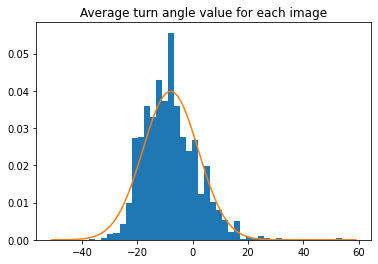

In [ ]:
mean_angles = df['mean_angle'].to_numpy()
_= plt.hist(mean_angles, bins='auto', density=True)
plt.title('Average turn angle value for each image')
(mean_angle, std_angle) = round(np.mean(mean_angles)), round(np.std(mean_angles))
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
plt.plot(x, norm.pdf(x, mean_angle, std_angle))
plt.show()

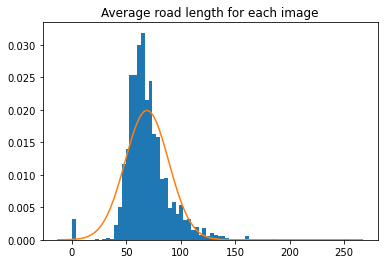

In [ ]:
mean_dists = df['avg_dist'].to_numpy()
_ = plt.hist(mean_dists, bins='auto', density=True)
plt.title('Average road length for each image')
(mean_dist, std_dist) = round(np.mean(mean_dists)), round(np.std(mean_dists))
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
plt.plot(x, norm.pdf(x, mean_dist, std_dist))
plt.show()

3 branches: 17727
4 branches: 6804
5 branches: 472
6 branches: 77
7 branches: 20


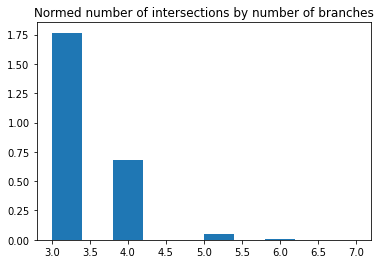

In [ ]:
inter_values = np.array([])
for i in range(3, 8):
  val = int(sum(df['inter_' + str(i)].to_numpy()))
  print(str(i) + ' branches: ' + str(val))
  inter_values = np.concatenate((inter_values, np.full(val, i, np.int)))

_ = plt.hist(inter_values, density=True)
plt.title('Normed number of intersections by number of branches')
plt.show()

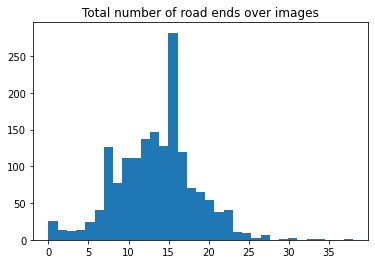

In [ ]:
nr_ends = df['nr_ends'].to_numpy()
_ = plt.hist(nr_ends, bins='auto', density=False)
plt.title('Total number of road ends over images')
plt.show()

In [ ]:
#Apply KMeans to cluster the images
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = df.drop(columns=['name'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=NR_CLUSTERS, max_iter=500)
kmeans.fit(scaled_features)

df['label'] = kmeans.labels_
grouped = df.groupby('label')

In [ ]:
for i in range(NR_CLUSTERS):
  print(grouped.get_group(i))
  print('======================================================================================')

                name  nr_ends  nr_angles  ...  inter_6  inter_7  label
7     image_1003.txt      9.0       11.0  ...      0.0      0.0      0
9     image_1005.txt      6.0       19.0  ...      0.0      0.0      0
10    image_1006.txt      6.0       10.0  ...      0.0      0.0      0
12    image_1008.txt      1.0       12.0  ...      0.0      0.0      0
13    image_1009.txt     14.0       17.0  ...      0.0      0.0      0
...              ...      ...        ...  ...      ...      ...    ...
1663   image_992.txt      7.0       12.0  ...      0.0      0.0      0
1665   image_994.txt     10.0       20.0  ...      0.0      0.0      0
1666   image_995.txt      9.0       18.0  ...      0.0      0.0      0
1667   image_996.txt     10.0       18.0  ...      0.0      0.0      0
1668   image_997.txt     10.0       10.0  ...      0.0      0.0      0

[842 rows x 18 columns]
                name  nr_ends  nr_angles  ...  inter_6  inter_7  label
0        image_0.txt     14.0       24.0  ...      1

In [ ]:
from scipy.stats import truncnorm
from random import choices

#normal distribution in a given interval
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [ ]:
#create a frequency array from a list of values 
def create_frequency(values):

  cnt = len(values)
  freq = np.zeros(360)
  for val in values:
    val = round(val)
    freq[val] += 1

  for val in range(360):
   freq[val] = freq[val] / cnt

  return freq

In [ ]:
#generate new elements relevant to the given cluster
def generate_samples_from_cluster(cluster, last_element):

  mean_min_dist = np.min(cluster['min_dist'].to_numpy())
  mean_max_dist = np.max(cluster['max_dist'].to_numpy())
  (mean_dist, std_dist) = round(np.mean(cluster['avg_dist'].to_numpy())), round(np.std(cluster['avg_dist'].to_numpy()))

  mean_min_angle = np.min(cluster['min_angle'].to_numpy())
  mean_max_angle = np.max(cluster['max_angle'].to_numpy())
  (mean_angle, std_angle) = round(np.mean(cluster['mean_angle'].to_numpy())), round(np.std(cluster['mean_angle'].to_numpy()))

  angles_freq = create_frequency(np.abs(cluster['mean_angle'].to_numpy()))

  sum_inters = cluster[['nr_inter', 'inter_3', 'inter_4', 'inter_5', 'inter_6', 'inter_7']].sum(axis=0)
  labels = range(8)
  weights = np.zeros(8)
  weights[0] = 0.0
  weights[1] = 0.0
  weights[2] = 0.0
  weights[3] = sum_inters['inter_3'] / sum_inters['nr_inter']
  weights[4] = sum_inters['inter_4'] / sum_inters['nr_inter']
  weights[5] = sum_inters['inter_5'] / sum_inters['nr_inter']
  weights[6] = sum_inters['inter_6'] / sum_inters['nr_inter']
  weights[7] = sum_inters['inter_7'] / sum_inters['nr_inter']

  sum_occurences = cluster[['nr_dists', 'nr_angles', 'nr_inter', 'nr_ends']].sum(axis=0)

  if std_dist <= 0.0:
    std_dist = 1.0
  
  if std_angle <= 0.0:
    std_angle = 1.0

  if mean_min_dist == mean_max_dist:
    mean_max_dist += 0.00001

  if mean_min_angle == mean_max_angle:
    mean_max_angle += 0.00001

  angle_val = round(get_truncated_normal(mean_angle, std_angle, mean_min_angle, mean_max_angle).rvs()) * ((-1)**(random.randint(1, 2)))

  res_dist = 'DIST_' + str(round(get_truncated_normal(mean_dist, std_dist, mean_min_dist, mean_max_dist).rvs()))
  res_angle = 'ANGLE_' + str(angle_val)
  res_inter = 'INTER_' + str(choices(labels, weights)[0])
  res_end = 'END_' + str(True)

  total_sum = 0
  probabilities = []

  #reduce number of ends so the generation wont stop that fast
  sum_occurences['nr_ends'] = sum_occurences['nr_ends'] // 1000

  #if we generated a straight road, we will generate either an angle, an intersection or a road end (gave a little more chance to intersections)
  if last_element.startswith('DIST'):
    total_sum = sum_occurences['nr_angles'] + round(1.5 * sum_occurences['nr_inter']) + sum_occurences['nr_ends']
    probabilities = [0.0, (sum_occurences['nr_angles'] / total_sum), (round(1.5 * sum_occurences['nr_inter']) / total_sum), (sum_occurences['nr_ends'] / total_sum)]

  #if we generated an angle, we will generated a straight road so the turn in road can be observed
  elif last_element.startswith('ANGLE'):
    probabilities = [1.0, 0.0, 0.0, 0.0]

  #if we need a remake to prevent overlapping, with existing road, try a new angle
  elif last_element.startswith('REMAKE'):
    probabilities = [0.0, 1.0, 0.0, 0.0]

  #if we generated an intersection, we will generate an angle so we can separate its branches
  elif last_element.startswith('INTER'):
    probabilities = [0.0, 1.0, 0.0, 0.0]
    forced_angle = int(last_element.strip().split('_')[1])
    res_angle = 'ANGLE_' + str(forced_angle)
   
  return ([res_dist, res_angle, res_inter, res_end], probabilities)


In [ ]:
#based on the cluster and previous element, generate next element
def generate_next_element(cluster, last_element):
  results, weights = generate_samples_from_cluster(cluster, last_element)
  return choices(results, weights)[0]

In [ ]:
cluster = grouped.get_group(np.random.randint(NR_CLUSTERS))

In [ ]:
#given a point, get the equivalent point at a given distance and given angle
def apply_translation_to(position, angle, distance):
  x = distance * math.cos(math.radians(angle))
  y = distance * math.sin(math.radians(angle))
  return (position[0] + x, position[1] + y)

#rotate a position to left with a number of degrees
def rotate_left(position, degree_angle):
  (x, y) = position
  adjustedX = (x * math.cos(math.radians(degree_angle))) - (y * math.sin(math.radians(degree_angle)))
  adjustedY = (y * math.cos(math.radians(degree_angle))) + (x * math.sin(math.radians(degree_angle)))
  return (round(adjustedX), round(adjustedY))

#given a position, get the point at a certaing angle and distance
def get_position_of(last_position, angle, distance, angle_adjustment=0):
  rotated_left_position = rotate_left(last_position, 360 - angle_adjustment)
  translated_location = apply_translation_to(rotated_left_position, angle, distance)
  return rotate_left(translated_location, angle_adjustment)

In [ ]:
class RoadPatch():
  def __init__(self, name=''):
    self.name = name
    self.edges = []
    self.start_points = []
    self.end_points_top = []
    self.end_points_bottom = []
    self.end_points_left = []
    self.end_points_right = []
  
  def get_coded_edges(self):
    coded_edges = []
    for edge in self.edges:
      coded_edges.append((encode_position(edge[0]), encode_position(edge[1])))
    return coded_edges


In [ ]:
Q_TOP_LEFT = 0
Q_TOP = 1
Q_TOP_RIGHT = 2
Q_LEFT = 3
Q_MIDDLE = 4
Q_RIGHT = 5
Q_BOTTOM_LEFT = 6
Q_BOTTOM = 7
Q_BOTTOM_RIGHT = 8

PATCHES = []

def get_quadrant_by_index(index):

  if index == 0: return Q_TOP_LEFT
  elif index == 1: return Q_TOP
  elif index == 2: return Q_TOP_RIGHT
  elif index == 3: return Q_LEFT
  elif index == 4: return Q_MIDDLE
  elif index == 5: return Q_RIGHT
  elif index == 6: return Q_BOTTOM_LEFT
  elif index == 7: return Q_BOTTOM
  elif index == 8: return Q_BOTTOM_RIGHT

def get_quadrant(position, dim=IMG_DIM):

  (x, y) = position

  if x < 0:
    if y < 0: return Q_TOP_LEFT
    if y >= dim: return Q_TOP_RIGHT
    return Q_TOP

  if x >= dim:
    if y < 0: return Q_BOTTOM_LEFT
    if y >= dim: return Q_BOTTOM_RIGHT
    return Q_BOTTOM

  if y < 0:
    return Q_LEFT
  
  if y >= dim:
    return Q_RIGHT

  return Q_MIDDLE

In [ ]:
#generate road based on a cluster
def generate_road_rec(patch, cluster, position, prev_position, angle_adjustment, next_element, steps, current_quadrant):

  #condition to stop the recursion chain when a certain depth is reached
  if steps > 20:
    return

  #condition to stop the recursion chain if we leave the working space we defined
  if is_out_of_bounds(position, IMG_DIM):
    
    rr, cc = line(prev_position[0], prev_position[1], position[0], position[1])
    new_quadrant = get_quadrant(position)
    idx = -1

    if new_quadrant in [Q_TOP_LEFT, Q_TOP, Q_TOP_RIGHT]:
      idxx = ((rr == 0) & (cc >= 0) & (cc < IMG_DIM)).nonzero()[0]
      if len(idxx) > 0:
        idx = idxx[0]
        patch.end_points_top.append((rr[idx], cc[idx]))
    elif new_quadrant in [Q_BOTTOM_LEFT, Q_BOTTOM, Q_BOTTOM_RIGHT]:
      idxx = ((rr == (IMG_DIM - 1)) & (cc >= 0) & (cc < IMG_DIM)).nonzero()[0]
      if len(idxx) > 0:
        idx = idxx[0]
        patch.end_points_bottom.append((rr[idx], cc[idx]))
    elif new_quadrant in [Q_LEFT]:
      idxx = ((cc == 0) & (rr >= 0) & (rr < IMG_DIM)).nonzero()[0]
      if len(idxx) > 0:
        idx = idxx[0] 
        patch.end_points_left.append((rr[idx], cc[idx]))
    elif new_quadrant in [Q_RIGHT]:
      idxx = ((cc == (IMG_DIM - 1)) & (rr >= 0) & (rr < IMG_DIM)).nonzero()[0]
      if len(idxx) > 0:
        idx = idxx[0]
        patch.end_points_right.append((rr[idx], cc[idx]))
   
    if idx != -1:
      position = (rr[idx], cc[idx])
      patch.edges.append((prev_position, position))
    return

  #print(next_element, steps)

  #print the graph edges to the file
  if encode_position(prev_position) != encode_position(position):
    patch.edges.append((prev_position, position))

  #if we generated a road end, we stop generating further from this point
  if next_element.startswith('END') == True:
    return

  #if we generate a direct road
  elif next_element.startswith('DIST') == True:
    #get its length
    dist = int(next_element.strip().split('_')[1])
    #determine the coordinates of the next point
    next_pos = get_position_of(position, 0, dist, angle_adjustment)
    #prevent self intersections, in case of self intersection, retry at a different angle
    if intersects_any((position, next_pos), patch.edges) == False:
      generate_road_rec(patch, cluster, next_pos, position, angle_adjustment, generate_next_element(cluster, 'DIST'), steps + 1, current_quadrant)
    else:
      #print('Overlapping: ' + str(next_pos) + ' from ' + str(position))
      generate_road_rec(patch, cluster, position, prev_position, angle_adjustment, generate_next_element(cluster, 'REMAKE'), steps, current_quadrant)

  #if we generate a new angle
  elif next_element.startswith('ANGLE') == True:
    #get the degrees
    angle = (int(next_element.strip().split('_')[1]))
    #determine the coordinates of the next point
    next_pos = get_position_of(position, angle, 0, angle_adjustment)
    generate_road_rec(patch, cluster, next_pos, position, angle_adjustment + angle, generate_next_element(cluster, 'ANGLE'), steps + 1, current_quadrant)

  #if we generate an intersection
  elif next_element.startswith('INTER') == True:
    #we want the angle between two consecutive of its branches to be at least 50 degrees, to look realistic
    MIN_INTER_ANGLE = 45
    inter_num = int(next_element.strip().split('_')[1])
    prev_angle = -180
    angle_sum = 0
    #for each branch, generate a new road
    for i in range(inter_num - 1):
      remaining = (360 - angle_sum - ((inter_num - i) * MIN_INTER_ANGLE))
      if (MIN_INTER_ANGLE > remaining):
        print("Problem with intersections", remaining, inter_num, angle_sum)
      gen_angle = random.randint(MIN_INTER_ANGLE, remaining)
      forced_angle = prev_angle + gen_angle
      angle_sum += gen_angle
      prev_angle = forced_angle
      #print(steps, ': ', inter_num, ' -> ', forced_angle)
      generate_road_rec(patch, cluster, get_position_of(position, 0, 0, angle_adjustment), position, angle_adjustment, generate_next_element(cluster, 'INTER_' + str(forced_angle)), steps + 1, current_quadrant)
      

In [ ]:
TO_LEFT = 0
TO_TOP = 1
TO_RIGHT = 2
TO_BOTTOM = 3

def move_points_between_patches(points, dir, angle):

  new_start_points = []

  if dir == TO_LEFT:
    for (x, y) in points:
      new_start_points.append(((x, IMG_DIM-1), angle))

  elif dir == TO_TOP:
    for (x, y) in points:
      new_start_points.append(((IMG_DIM-1, y), angle))

  elif dir == TO_RIGHT:
    for (x, y) in points:
      new_start_points.append(((x, 0), angle))

  elif dir == TO_BOTTOM:
    for (x, y) in points:
      new_start_points.append(((0, y), angle))

  return new_start_points

def propagate_patches():

  for i in range(9):
    if i == Q_TOP_LEFT:
      PATCHES[Q_TOP].start_points = PATCHES[Q_TOP].start_points + move_points_between_patches(PATCHES[i].end_points_right, TO_RIGHT, 90)
      PATCHES[Q_LEFT].start_points = PATCHES[Q_LEFT].start_points + move_points_between_patches(PATCHES[i].end_points_bottom, TO_BOTTOM, 0)
 
    elif i == Q_TOP:
      PATCHES[Q_TOP_LEFT].start_points = PATCHES[Q_TOP_LEFT].start_points + move_points_between_patches(PATCHES[i].end_points_left, TO_LEFT, -90)
      PATCHES[Q_TOP_RIGHT].start_points = PATCHES[Q_TOP_RIGHT].start_points + move_points_between_patches(PATCHES[i].end_points_right, TO_RIGHT, 90)
      PATCHES[Q_MIDDLE].start_points = PATCHES[Q_MIDDLE].start_points + move_points_between_patches(PATCHES[i].end_points_bottom, TO_BOTTOM, 0)
 
    elif i == Q_TOP_RIGHT:
      PATCHES[Q_TOP].start_points = PATCHES[Q_TOP].start_points + move_points_between_patches(PATCHES[i].end_points_left, TO_LEFT, -90)
      PATCHES[Q_RIGHT].start_points = PATCHES[Q_RIGHT].start_points + move_points_between_patches(PATCHES[i].end_points_bottom, TO_BOTTOM, 0)
 
    elif i == Q_LEFT:
      PATCHES[Q_TOP_LEFT].start_points = PATCHES[Q_TOP_LEFT].start_points + move_points_between_patches(PATCHES[i].end_points_top, TO_TOP, 180)
      PATCHES[Q_MIDDLE].start_points = PATCHES[Q_MIDDLE].start_points + move_points_between_patches(PATCHES[i].end_points_right, TO_RIGHT, 90)
      PATCHES[Q_BOTTOM_LEFT].start_points = PATCHES[Q_BOTTOM_LEFT].start_points + move_points_between_patches(PATCHES[i].end_points_bottom, TO_BOTTOM, 0)
 
    elif i == Q_MIDDLE:
      PATCHES[Q_TOP].start_points = PATCHES[Q_TOP].start_points + move_points_between_patches(PATCHES[i].end_points_top, TO_TOP, 180)
      PATCHES[Q_LEFT].start_points = PATCHES[Q_LEFT].start_points + move_points_between_patches(PATCHES[i].end_points_left, TO_LEFT, -90)
      PATCHES[Q_RIGHT].start_points = PATCHES[Q_RIGHT].start_points + move_points_between_patches(PATCHES[i].end_points_right, TO_RIGHT, 90)
      PATCHES[Q_BOTTOM].start_points = PATCHES[Q_BOTTOM].start_points + move_points_between_patches(PATCHES[i].end_points_bottom, TO_BOTTOM, 0)
 
    elif i == Q_RIGHT:
      PATCHES[Q_TOP_RIGHT].start_points = PATCHES[Q_TOP_RIGHT].start_points + move_points_between_patches(PATCHES[i].end_points_top, TO_TOP, 180)
      PATCHES[Q_MIDDLE].start_points = PATCHES[Q_MIDDLE].start_points + move_points_between_patches(PATCHES[i].end_points_left, TO_LEFT, -90)
      PATCHES[Q_BOTTOM_RIGHT].start_points = PATCHES[Q_BOTTOM_RIGHT].start_points + move_points_between_patches(PATCHES[i].end_points_bottom, TO_BOTTOM, 0)

    elif i == Q_BOTTOM_LEFT:
      PATCHES[Q_LEFT].start_points = PATCHES[Q_LEFT].start_points + move_points_between_patches(PATCHES[i].end_points_top, TO_TOP, 180)
      PATCHES[Q_BOTTOM].start_points = PATCHES[Q_BOTTOM].start_points + move_points_between_patches(PATCHES[i].end_points_right, TO_RIGHT, 90)

    elif i == Q_BOTTOM:
      PATCHES[Q_MIDDLE].start_points = PATCHES[Q_MIDDLE].start_points + move_points_between_patches(PATCHES[i].end_points_top, TO_TOP, 180)
      PATCHES[Q_BOTTOM_LEFT].start_points = PATCHES[Q_BOTTOM_LEFT].start_points + move_points_between_patches(PATCHES[i].end_points_left, TO_LEFT, -90)
      PATCHES[Q_BOTTOM_RIGHT].start_points = PATCHES[Q_BOTTOM_RIGHT].start_points + move_points_between_patches(PATCHES[i].end_points_right, TO_RIGHT, 90)

    elif i == Q_BOTTOM_RIGHT:
      PATCHES[Q_RIGHT].start_points = PATCHES[Q_RIGHT].start_points + move_points_between_patches(PATCHES[i].end_points_top, TO_TOP, 180)
      PATCHES[Q_BOTTOM].start_points = PATCHES[Q_BOTTOM].start_points + move_points_between_patches(PATCHES[i].end_points_left, TO_LEFT, -90)      

    PATCHES[i].end_points_bottom = []
    PATCHES[i].end_points_top = []
    PATCHES[i].end_points_left = []
    PATCHES[i].end_points_right = []    

In [ ]:
def shift_patches(dir):

  if dir == TO_LEFT:
    PATCHES[Q_TOP_LEFT] = PATCHES[Q_TOP]
    PATCHES[Q_TOP] = PATCHES[Q_TOP_RIGHT]
    PATCHES[Q_TOP_RIGHT] = RoadPatch()
    PATCHES[Q_LEFT] = PATCHES[Q_MIDDLE]
    PATCHES[Q_MIDDLE] = PATCHES[Q_RIGHT]
    PATCHES[Q_RIGHT] = RoadPatch()
    PATCHES[Q_BOTTOM_LEFT] = PATCHES[Q_BOTTOM]
    PATCHES[Q_BOTTOM] = PATCHES[Q_BOTTOM_RIGHT]
    PATCHES[Q_BOTTOM_RIGHT] = RoadPatch()

  elif dir == TO_TOP:
    PATCHES[Q_TOP_LEFT] = PATCHES[Q_LEFT]
    PATCHES[Q_LEFT] = PATCHES[Q_BOTTOM_LEFT]
    PATCHES[Q_BOTTOM_LEFT] = RoadPatch()
    PATCHES[Q_TOP] = PATCHES[Q_MIDDLE]
    PATCHES[Q_MIDDLE] = PATCHES[Q_BOTTOM]
    PATCHES[Q_BOTTOM] = RoadPatch()
    PATCHES[Q_TOP_RIGHT] = PATCHES[Q_RIGHT]
    PATCHES[Q_RIGHT] = PATCHES[Q_BOTTOM_RIGHT]
    PATCHES[Q_BOTTOM_RIGHT] = RoadPatch()

  elif dir == TO_RIGHT:
    PATCHES[Q_TOP_RIGHT] = PATCHES[Q_TOP]
    PATCHES[Q_TOP] = PATCHES[Q_TOP_LEFT]
    PATCHES[Q_TOP_LEFT] = RoadPatch()
    PATCHES[Q_RIGHT] = PATCHES[Q_MIDDLE]
    PATCHES[Q_MIDDLE] = PATCHES[Q_LEFT]
    PATCHES[Q_LEFT] = RoadPatch()
    PATCHES[Q_BOTTOM_RIGHT] = PATCHES[Q_BOTTOM]
    PATCHES[Q_BOTTOM] = PATCHES[Q_BOTTOM_LEFT]
    PATCHES[Q_BOTTOM_LEFT] = RoadPatch()

  elif dir == TO_BOTTOM:
    PATCHES[Q_BOTTOM_LEFT] = PATCHES[Q_LEFT]
    PATCHES[Q_LEFT] = PATCHES[Q_TOP_LEFT]
    PATCHES[Q_TOP_LEFT] = RoadPatch()
    PATCHES[Q_BOTTOM] = PATCHES[Q_MIDDLE]
    PATCHES[Q_MIDDLE] = PATCHES[Q_TOP]
    PATCHES[Q_TOP] = RoadPatch()
    PATCHES[Q_BOTTOM_RIGHT] = PATCHES[Q_RIGHT]
    PATCHES[Q_RIGHT] = PATCHES[Q_TOP_RIGHT]
    PATCHES[Q_TOP_RIGHT] = RoadPatch()

In [ ]:
from multiprocessing import Process, Manager
import copy
def run_for_patch(aux_patches, patch, cluster, idx, next_elem):

  if len(patch.edges) > 0:
    return 

  for start_point, angle_adj in patch.start_points:
    generate_road_rec(patch, cluster, start_point, start_point, angle_adj, next_elem, 0, idx)

  aux_patches[idx] = copy.deepcopy(patch) 

#generate road
def generate_road():

  global PATCHES

  #select a cluster
  cluster = grouped.get_group(np.random.randint(NR_CLUSTERS))
  results, _ = generate_samples_from_cluster(cluster, 'ANGLE')

  
  with Manager() as manager:
    procs = []
    aux_patches = manager.list(range(9))
    for i in range(9):
      #run_for_patch(PATCHES[i], cluster, i, results[0])
      procs.append(Process(target=run_for_patch, args=(aux_patches, copy.deepcopy(PATCHES[i]), cluster, i, results[0])))
      procs[-1].start()
    
    for p in procs:
      p.join()
    
    PATCHES = copy.deepcopy(aux_patches)


In [ ]:
import time
global PATCHES
PATCHES = [RoadPatch('PATCH' + str(i)) for i in range(9)]
#choose a starting points
for i in range(9):
  PATCHES[i].start_points = [((255, 255), -135), ((255, 255), 135), ((255, 255), 0)]

start_time = time.time()
generate_road()
end_time = time.time()
print(end_time - start_time)

23.10753083229065


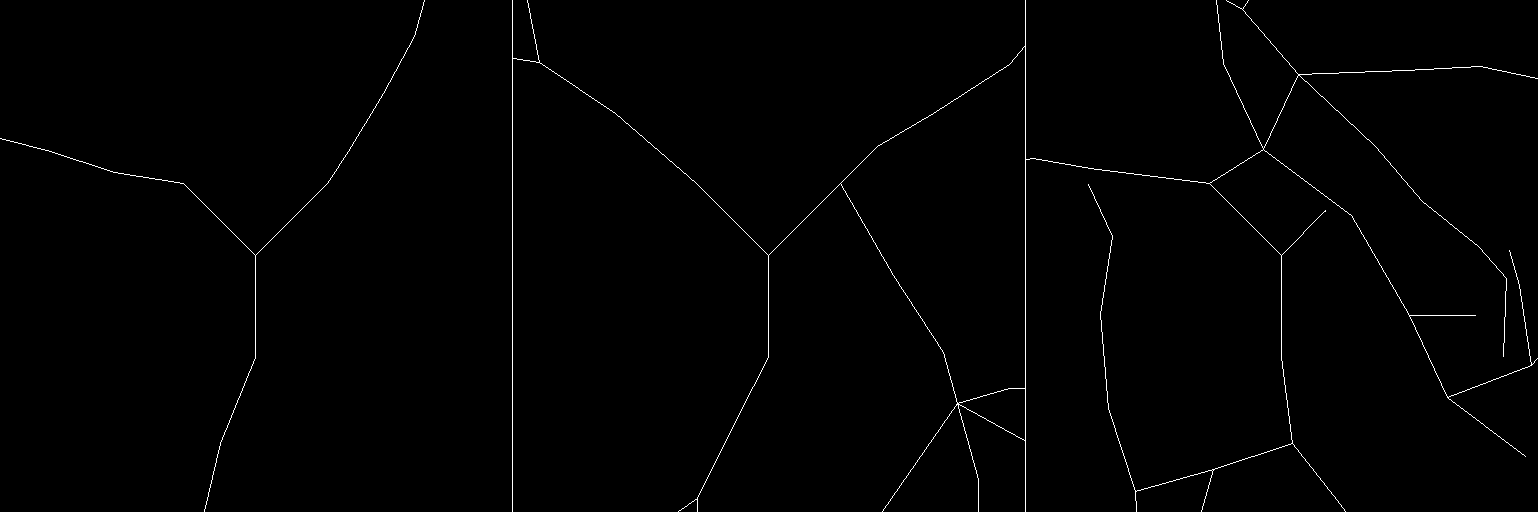

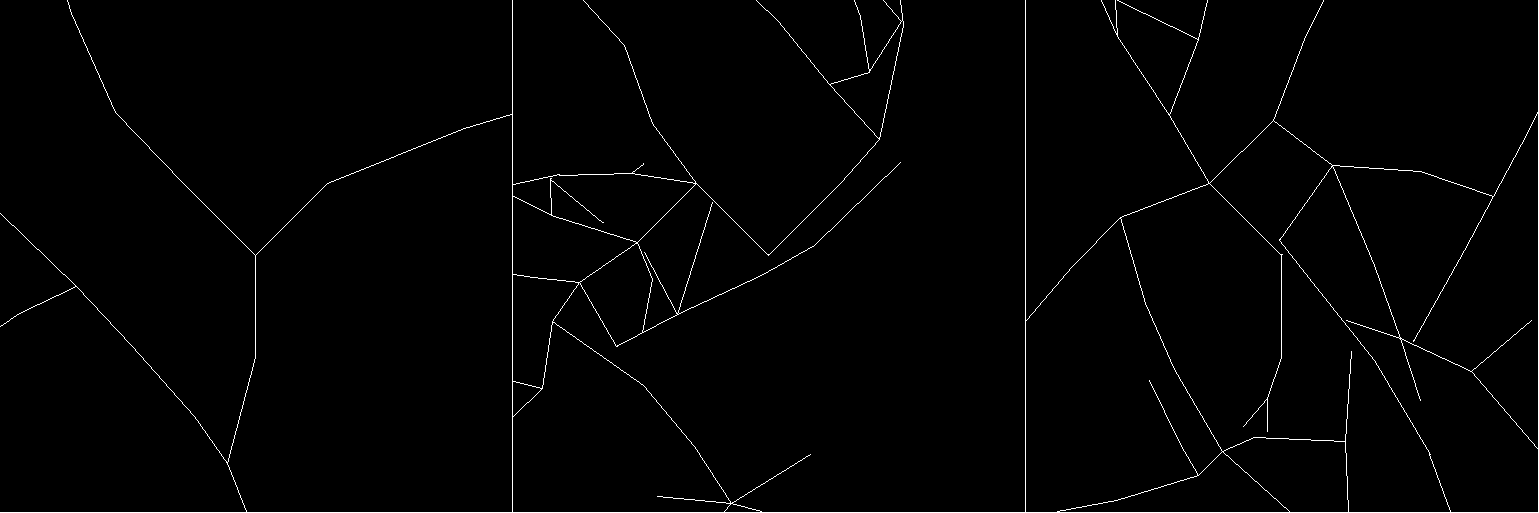

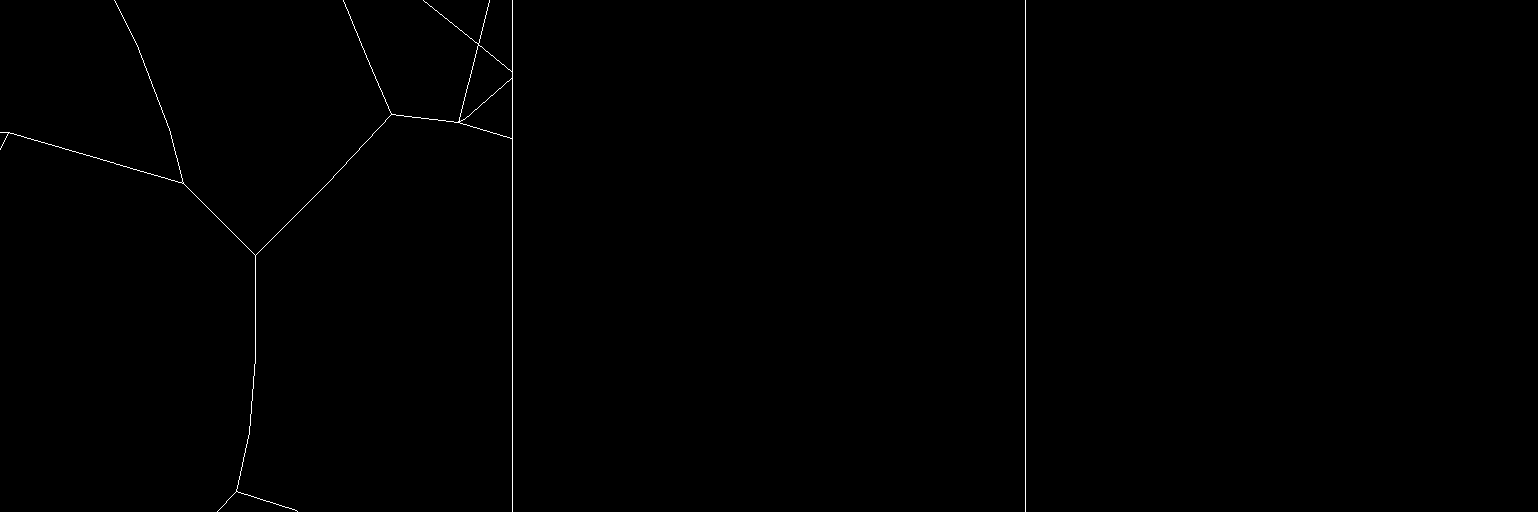

In [ ]:
#graph = read_graphs("/content/generated_graphs")[0]
results = []
for i in range(9):
  results.append(create_image_from_graph(PATCHES[i].get_coded_edges()))

#cv2_imshow(results[Q_MIDDLE])
display_image_compare(results[0], results[1], results[2])
display_image_compare(results[3], results[4], results[5])
display_image_compare(results[6], results[7], results[8]) 

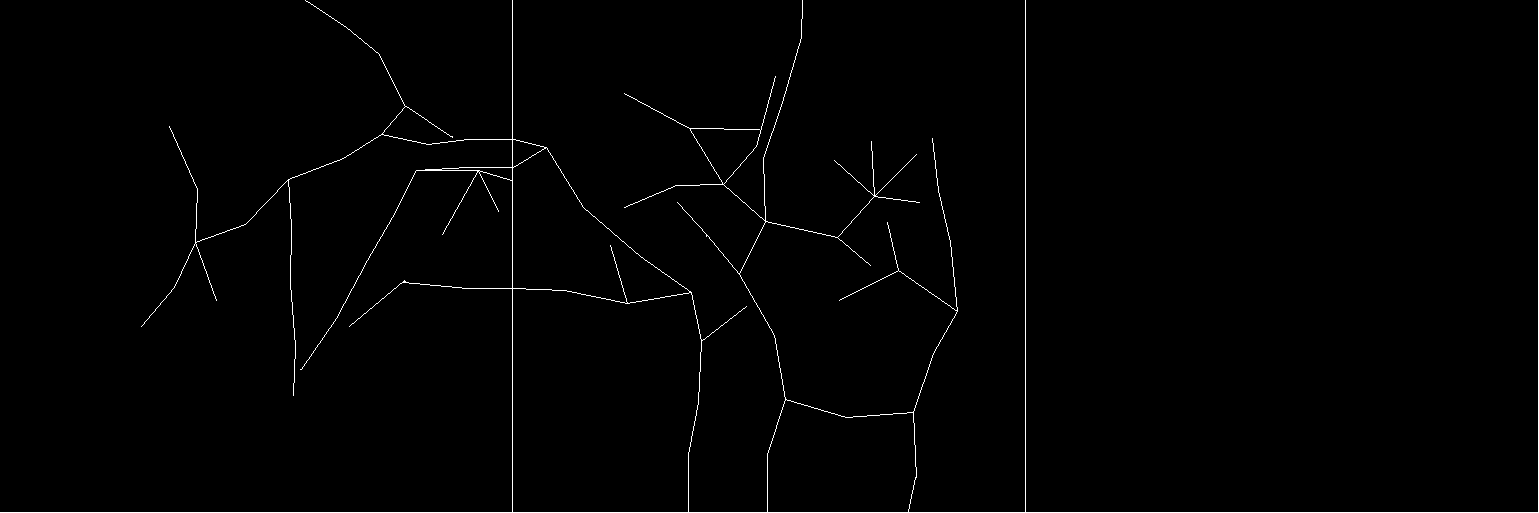

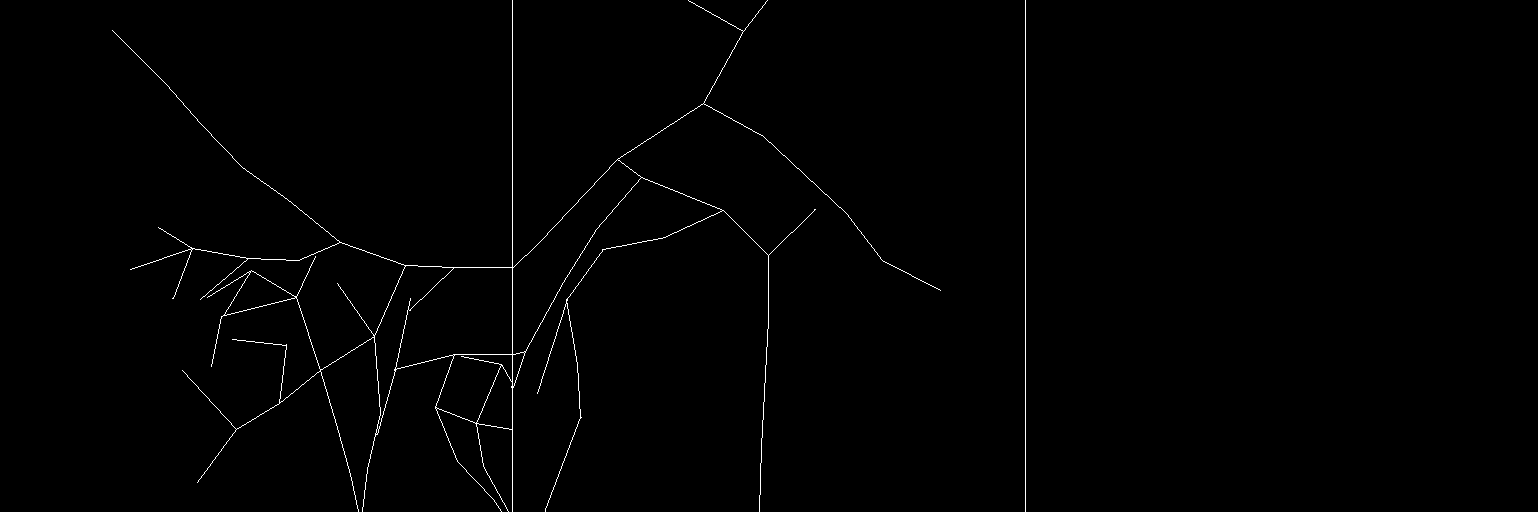

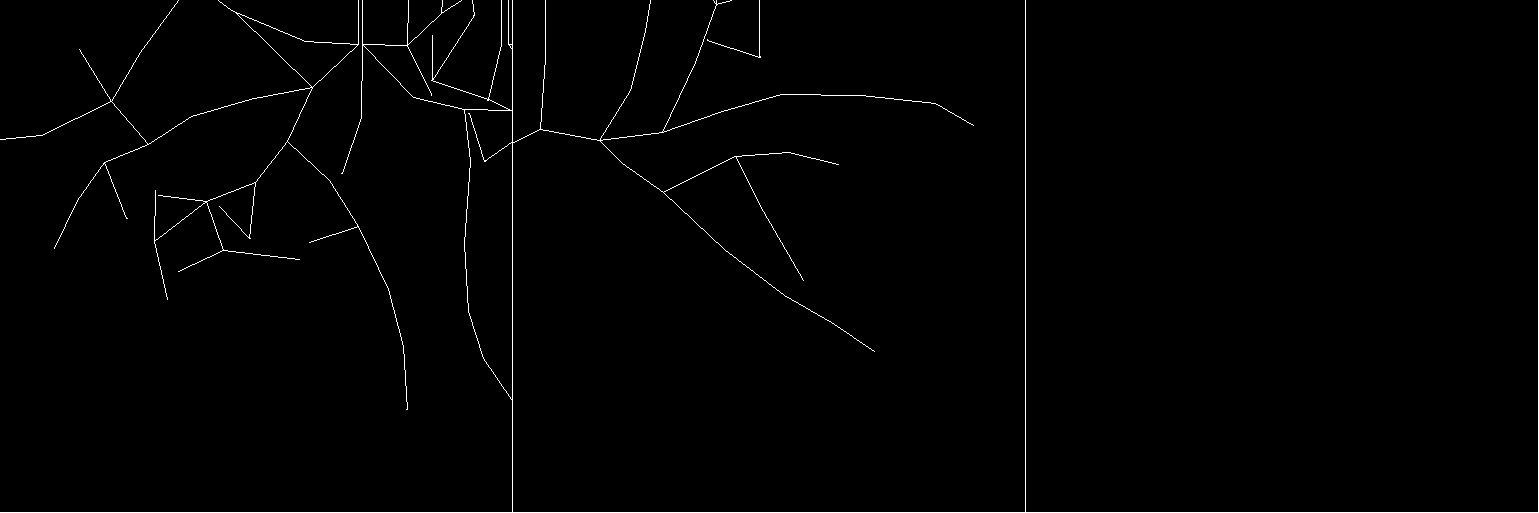

In [ ]:
global PATCHES
PATCHES = [RoadPatch('PATCH' + str(i)) for i in range(9)]
#choose a starting points
PATCHES[Q_MIDDLE].start_points = [((255, 255), -135), ((255, 255), 135), ((255, 255), 0)]

generate_road()
propagate_patches()
generate_road()
propagate_patches()
generate_road()


#graph = read_graphs("/content/generated_graphs")[0]
results = []
for i in range(9):
  results.append(create_image_from_graph(PATCHES[i].get_coded_edges()))

#cv2_imshow(results[Q_MIDDLE])
display_image_compare(results[0], results[1], results[2])
display_image_compare(results[3], results[4], results[5])
display_image_compare(results[6], results[7], results[8])  

In [ ]:
PATCHES[Q_MIDDLE].name

'PATCH4'

In [ ]:
shift_patches(TO_BOTTOM)

In [ ]:
propagate_patches()
generate_road()

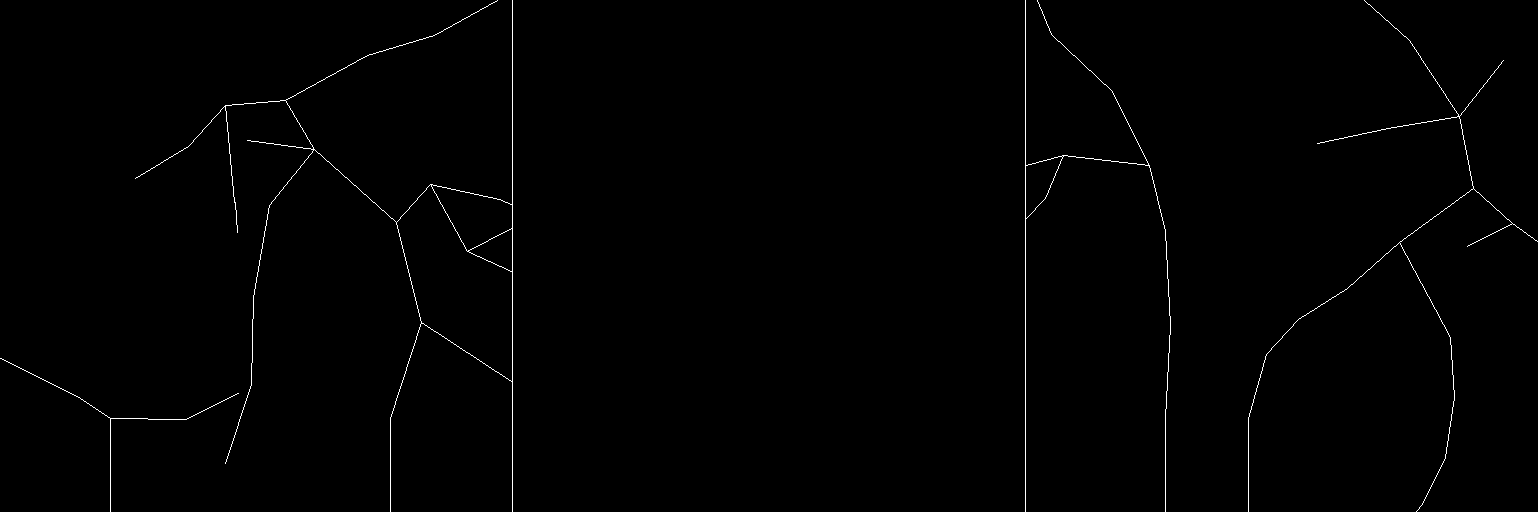

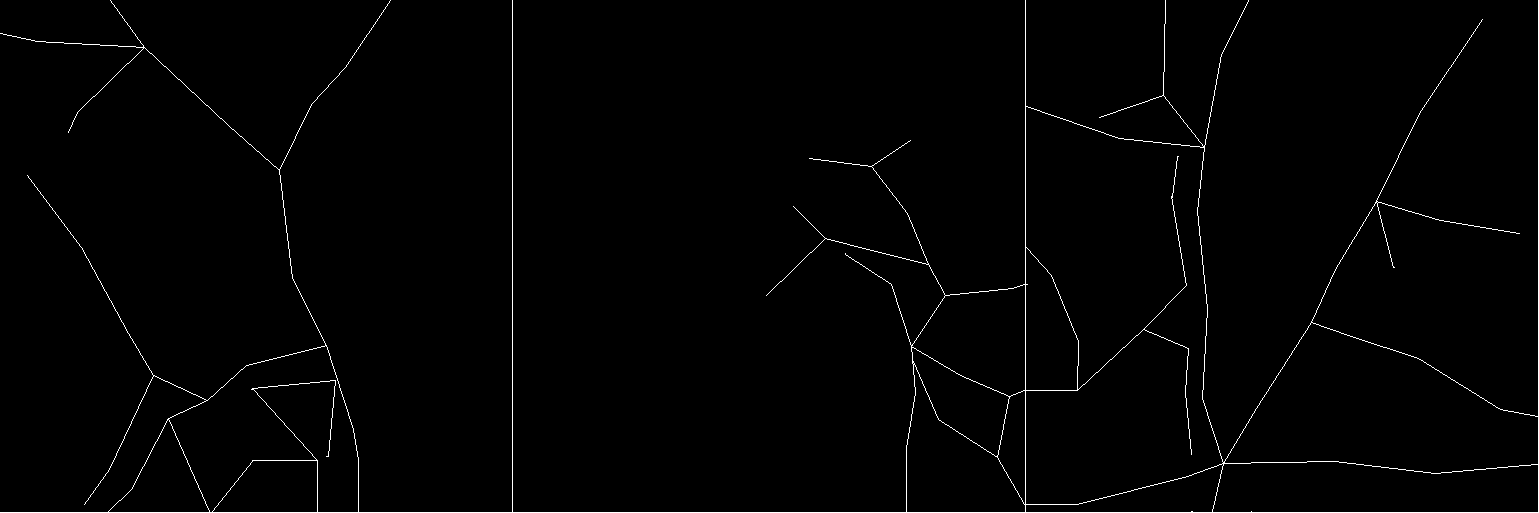

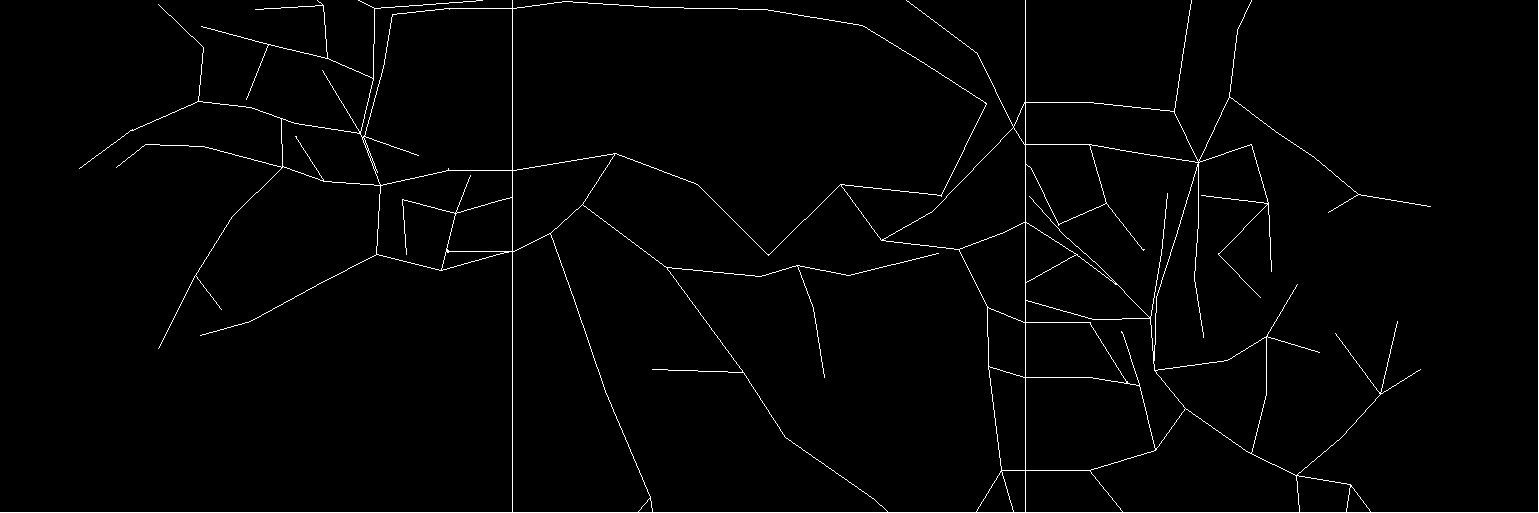

In [ ]:
results = []
for i in range(9):
  results.append(create_image_from_graph(PATCHES[i].get_coded_edges()))

#cv2_imshow(results[Q_MIDDLE])
display_image_compare(results[0], results[1], results[2])
display_image_compare(results[3], results[4], results[5])
display_image_compare(results[6], results[7], results[8])  